In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

2025-06-15 13:27:43.955807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749994064.415869      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749994064.568879      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/sensor-based-american-sign-language-recognition/'

all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

df_list = []
for f in all_files:
    temp_df = pd.read_csv(f)
    match = re.search(r'sensors_data_(\d+)\.csv', f)
    user_id = int(match.group(1)) if match else 0 # Assign user 0 for 'pause_sign.csv'
    temp_df['user'] = user_id
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

print("--- Data Loaded and Combined Successfully ---")
print(f"Total rows: {len(df)}, Total columns: {len(df.columns)}")

--- Data Loaded and Combined Successfully ---
Total rows: 2590, Total columns: 442


In [3]:
label_col = 'SIGN'
user_col = 'user'

sensor_cols = df.select_dtypes(include=np.number).drop(columns=[user_col]).columns.tolist()

label_encoder = LabelEncoder()
df['sign_encoded'] = label_encoder.fit_transform(df[label_col])
num_classes = len(label_encoder.classes_)

scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

print("--- Data Preprocessing Successful ---")
print(f"Found {len(sensor_cols)} sensor features and {num_classes} unique signs.")

--- Data Preprocessing Successful ---
Found 439 sensor features and 8 unique signs.


In [4]:
# --- CREATE SEQUENCES FOR CROSS-VALIDATION ---
def create_sequences(data, time_steps=50, step=25):
    sequences, labels, groups = [], [], []
    
    for _, group in data.groupby(['user', 'sign_encoded']):
        for i in range(0, len(group) - time_steps, step):
            sequences.append(group[sensor_cols].iloc[i:i + time_steps].values)
            labels.append(group['sign_encoded'].iloc[i])
            groups.append(group['user'].iloc[i]) 
    return np.array(sequences), np.array(labels), np.array(groups)

TIME_STEPS = 50
STEP = 25

X, y_int, groups = create_sequences(df, TIME_STEPS, STEP)

y = to_categorical(y_int, num_classes=num_classes)

print(f"Shape of all sequences (X): {X.shape}")
print(f"Shape of all labels (y): {y.shape}")
print(f"Found {len(np.unique(groups))} unique user groups in the sequence data.")

Shape of all sequences (X): (56, 50, 439)
Shape of all labels (y): (56, 8)
Found 4 unique user groups in the sequence data.


In [5]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Group K-Fold Cross-Validation ---
n_groups = len(np.unique(groups))
N_SPLITS = n_groups
gkf = GroupKFold(n_splits=N_SPLITS)

print(f"--- Starting {N_SPLITS}-Fold Cross-Validation ---")

all_acc_scores = []
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Build the Model
    inputs = Input(shape=(TIME_STEPS, X_train.shape[2]))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.5)(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the Model
    print(f"Training on {len(np.unique(groups[train_idx]))} user groups, testing on {len(np.unique(groups[test_idx]))} user group(s)...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Evaluate and store results
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold + 1} Test Accuracy: {accuracy*100:.2f}%")
    all_acc_scores.append(accuracy)

print("\n\n--- Cross-Validation Summary ---")
print(f"Mean Accuracy: {np.mean(all_acc_scores)*100:.2f}%")
print(f"Standard Deviation of Accuracy: {np.std(all_acc_scores)*100:.2f}%")

--- Starting 4-Fold Cross-Validation ---

--- FOLD 1/4 ---


I0000 00:00:1749994084.601767      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749994084.602510      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training on 3 user groups, testing on 1 user group(s)...


I0000 00:00:1749994090.547653      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


Fold 1 Test Accuracy: 35.00%

--- FOLD 2/4 ---
Training on 3 user groups, testing on 1 user group(s)...
Fold 2 Test Accuracy: 66.67%

--- FOLD 3/4 ---
Training on 3 user groups, testing on 1 user group(s)...
Fold 3 Test Accuracy: 100.00%

--- FOLD 4/4 ---
Training on 3 user groups, testing on 1 user group(s)...
Fold 4 Test Accuracy: 100.00%


--- Cross-Validation Summary ---
Mean Accuracy: 75.42%
Standard Deviation of Accuracy: 27.01%




--- Training Final Model on All Data for Detailed Analysis ---

--- Starting Final Training ---
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1364 - loss: 2.1108 - val_accuracy: 0.2500 - val_loss: 2.0441
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2955 - loss: 1.9782 - val_accuracy: 0.5000 - val_loss: 1.9757
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3636 - loss: 1.8744 - val_accuracy: 0.6667 - val_loss: 1.9127
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5227 - loss: 1.8062 - val_accuracy: 0.6667 - val_loss: 1.8492
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6364 - loss: 1.7466 - val_accuracy: 0.8333 - val_loss: 1.7864
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6591 - loss: 1.6221 - val_accuracy: 0.8333 - val_loss: 1.7239
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7727 - loss: 1.5486 - val_accuracy: 0.8333 - val_loss: 1.6699
Epoch 8/50
1/1 ━━━━━━━━━━━━━━

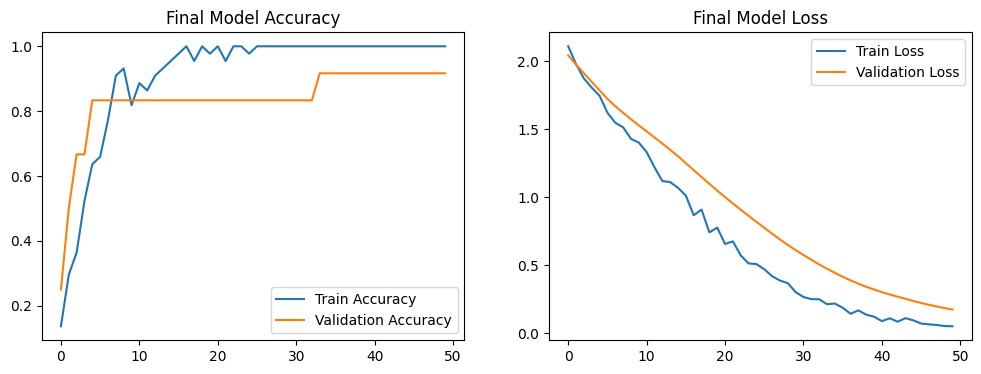



--- Final Model Performance Analysis (on all data) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

Classification Report:
              precision    recall  f1-score   support

       PAUSE       0.91      1.00      0.95        10
       PROUD       1.00      1.00      1.00         8
     STUDENT       1.00      1.00      1.00         8
   THANK YOU       1.00      1.00      1.00         8
        THIS       1.00      1.00      1.00         8
          WE       1.00      0.88      0.93         8
        WORK       1.00      1.00      1.00         6

    accuracy                           0.98        56
   macro avg       0.99      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56


Confusion Matrix:


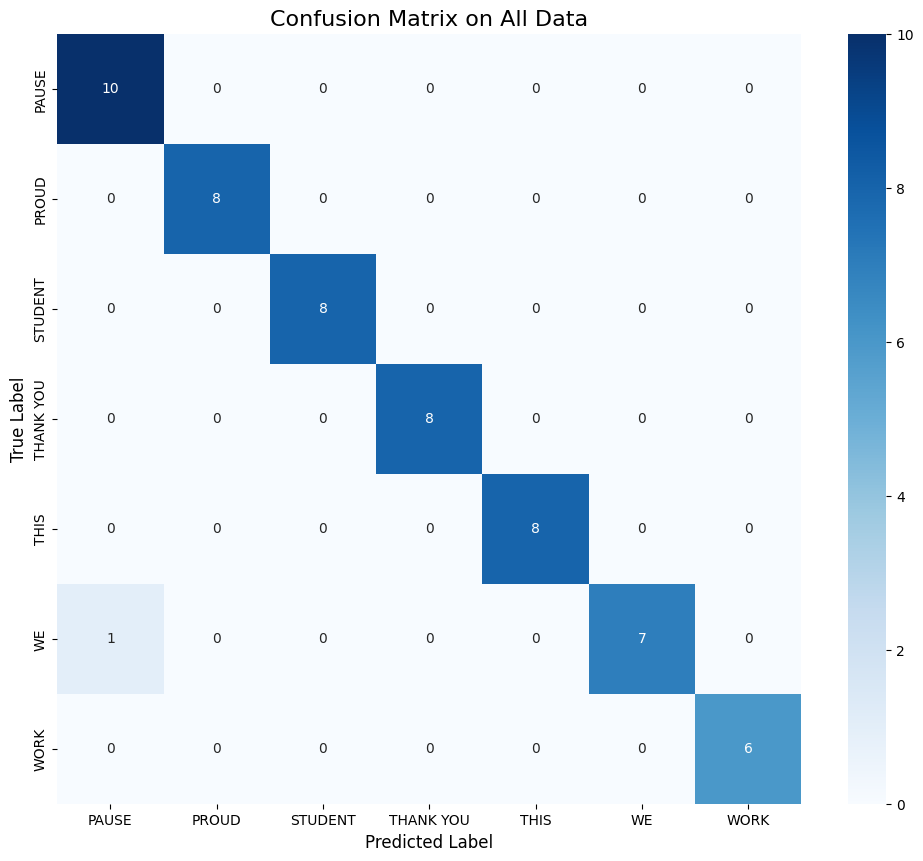

In [6]:
from sklearn.utils.multiclass import unique_labels

print("\n\n--- Training Final Model on All Data for Detailed Analysis ---")

inputs = Input(shape=(TIME_STEPS, X.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
final_model = Model(inputs=inputs, outputs=outputs)
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Final Training ---")
history = final_model.fit(
    X, y,
    epochs=50,
    batch_size=128,
    validation_split=0.2, # Use 20% of all data for validation monitoring
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# 3. Plot Training History
print("\n\n--- Final Model Training History ---")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.legend()
plt.show()

print("\n\n--- Final Model Performance Analysis (on all data) ---")
y_pred_probs = final_model.predict(X)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y, axis=1)

unique_labels_all = np.unique(np.concatenate((y_true, y_pred)))
filtered_class_names = [label_encoder.classes_[i] for i in unique_labels_all]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels_all, target_names=filtered_class_names, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred, labels=unique_labels_all)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=filtered_class_names, yticklabels=filtered_class_names, cmap='Blues')
plt.title('Confusion Matrix on All Data', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()